# Anomaly Detection with Logistic Regression

### Import Dependencies

In [106]:
# additional lib 
import datetime
import os
from typing import Callable, Optional
import pandas as pd
import json

# visualizations
import matplotlib.pyplot as plt
import matplotlib as matplot
import seaborn as sns

# modeling
from sklearn import preprocessing
import numpy as np
from torch_geometric.data import (
    Data,
    InMemoryDataset
)
import torch
import torch_geometric.transforms as T
from torch_geometric.loader import NeighborLoader
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")

### Load Dataset

In [107]:
pd.set_option('display.max_columns', None)
path = './data/hi_small_trxns.csv'
df = pd.read_csv(path)
df.head(10)
df = df.head(50000)
df.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022/09/01 00:20,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0
1,2022/09/01 00:20,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0
2,2022/09/01 00:00,3209,8000F4670,3209,8000F4670,14675.57,US Dollar,14675.57,US Dollar,Reinvestment,0
3,2022/09/01 00:02,12,8000F5030,12,8000F5030,2806.97,US Dollar,2806.97,US Dollar,Reinvestment,0
4,2022/09/01 00:06,10,8000F5200,10,8000F5200,36682.97,US Dollar,36682.97,US Dollar,Reinvestment,0


In [108]:
###################################################################################################
# Data Visualization Function - Helpers
###################################################################################################

def format_title_output(text):
    return f"{'++' * 50}\n{text.upper()}\n{'++' * 50}\n"


#Null data with heatmap
def create_null_data_heatmap(
    title=None, 
    rotate='horizontal',
    dataset=None
):
    try:
        plt.figure(figsize=(15,5))
        sns.heatmap(dataset.isnull(), cbar=False)
        plt.title(title, fontweight='bold')
        plt.xticks(rotation=rotate)
        plt.show()
    except Exception as error:
        print("**"*50)
        print("ERROR TO CREATE THE HEATMAP: ", error)
        print("**"*50)


#Null data with heatmap
def create_correlation_heatmap(
    title=None,
    dataset=None
):
    try:
        plt.figure(figsize=(15,8))
        correlation = dataset.corr()
        correlation = (correlation)
        sns.heatmap(correlation, 
                    xticklabels=correlation.columns.values,
                    yticklabels=correlation.columns.values, 
                    annot=True
        )
        plt.title(title, fontweight='bold')
        plt.show()
    except Exception as error:
        print("**"*50)
        print("ERROR TO CREATE THE HEATMAP: ", error)
        print("**"*50)

def create_boxplots(data, columns, ncols=2, figsize=(25, 6)):
    nrows = (len(columns) + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axes = axes.flatten() if nrows > 1 else axes
    for i, col in enumerate(columns):
        sns.boxplot(y=data[col], ax=axes[i])
        axes[i].set_title(col)
    for j in range(len(columns), len(axes)):
        axes[j].axis('off')
    plt.tight_layout()
    plt.show()


def create_histogram(data, column, figsize=(15, 4), color="g", kde=False):
    try:
        plt.figure(figsize=figsize)
        sns.histplot(data[column], kde=kde, color=color).set_title(f'{column[0]} Distribution', fontweight='bold')
        plt.title(f"{column[0]} Distribution", fontweight='bold')
        plt.show()
    except Exception as error:
        print("**"*50)
        print("ERROR TO CREATE THE HISTOGRAM: ", error)
        print("**"*50)
 
###################################################################################################
# Data Preprocessing - Helpers
###################################################################################################
def detect_outliers(data, columns):
    outlier_info = {}
    for col in columns:
        Q1 = data[col].quantile(0.25)  # First quartile (25th percentile)
        Q3 = data[col].quantile(0.75)  # Third quartile (75th percentile)
        IQR = Q3 - Q1  # Interquartile range
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
        max_outlier = outliers[col].max() if not outliers.empty else None

        outlier_info[col] = {
            "max_outlier_value": max_outlier,
            "number_of_outliers": outliers.shape[0],
            "lower_bound": lower_bound,
            "upper_bound": upper_bound,
        }

    return outlier_info

In [109]:
# Check the dataset info
print(format_title_output("DATASET INFO"))
print(df.info())

print("\n\n\n")
print(format_title_output("DATASET LENGTH"))
print("ROWS: ", df.shape[0])
print("COLUMNS: ", df.shape[1])

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
DATASET INFO
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Timestamp           50000 non-null  object 
 1   From Bank           50000 non-null  int64  
 2   Account             50000 non-null  object 
 3   To Bank             50000 non-null  int64  
 4   Account.1           50000 non-null  object 
 5   Amount Received     50000 non-null  float64
 6   Receiving Currency  50000 non-null  object 
 7   Amount Paid         50000 non-null  float64
 8   Payment Currency    50000 non-null  object 
 9   Payment Format      50000 non-null  object 
 10  Is Laundering       50000 non-null  int64  
dtypes: float64(2), int64(3), object(6

In [110]:
# rename the columns with lowercase and _ underscore if there is a space
print(format_title_output("DATASET NEW COLUMNS"))

df.columns = [col.lower().replace(" ", "_") for col in df.columns]
for i,j in enumerate(df.columns): 
    print(i, " : ", j)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
DATASET NEW COLUMNS
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

0  :  timestamp
1  :  from_bank
2  :  account
3  :  to_bank
4  :  account.1
5  :  amount_received
6  :  receiving_currency
7  :  amount_paid
8  :  payment_currency
9  :  payment_format
10  :  is_laundering


In [111]:
amount_consistency = df.loc[~(df['amount_received'] == df['amount_paid'])]
ccy_consistency = df.loc[~(df['receiving_currency'] == df['payment_currency'])]

print(format_title_output("AMOUNT CONSISTENCY - CREDIT & DEBIT"))
print(amount_consistency.shape)

print(format_title_output("CURRENCY CONSISTENCY - CREDIT & DEBIT"))
print(ccy_consistency.shape)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
AMOUNT CONSISTENCY - CREDIT & DEBIT
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

(114, 11)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
CURRENCY CONSISTENCY - CREDIT & DEBIT
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

(114, 11)


In [112]:
#Check the currency 

print(format_title_output("RECEIVED CURRENCY"))
print(sorted(df['receiving_currency'].unique()))
print("\n\n")

print(format_title_output("PAYMENT CURRENCY"))
print(sorted(df['payment_currency'].unique()))

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
RECEIVED CURRENCY
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

['Australian Dollar', 'Bitcoin', 'Euro', 'Mexican Peso', 'Rupee', 'UK Pound', 'US Dollar', 'Yen', 'Yuan']



++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
PAYMENT CURRENCY
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

['Australian Dollar', 'Bitcoin', 'Euro', 'Mexican Peso', 'Rupee', 'UK Pound', 'US Dollar', 'Yen', 'Yuan']


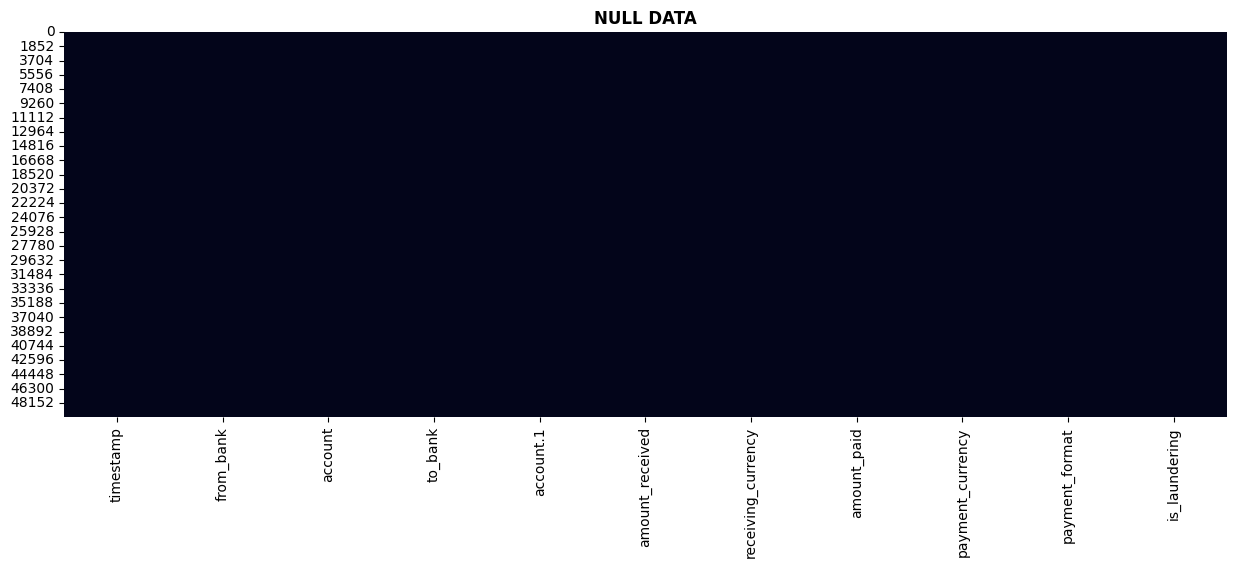

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
NULL DATA NUMBER
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

timestamp             0
from_bank             0
account               0
to_bank               0
account.1             0
amount_received       0
receiving_currency    0
amount_paid           0
payment_currency      0
payment_format        0
is_laundering         0
dtype: int64


In [113]:
create_null_data_heatmap("NULL DATA", 'vertical', df)
print(format_title_output("NULL DATA NUMBER"))
print(df.isnull().sum())

In [114]:
df.head()

,timestamp,from_bank,account,to_bank,account.1,amount_received,receiving_currency,amount_paid,payment_currency,payment_format,is_laundering
0,2022/09/01 00:20,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0
1,2022/09/01 00:20,3208,8000F4580,1,8000F5340,0.01,US Dollar,0.01,US Dollar,Cheque,0
2,2022/09/01 00:00,3209,8000F4670,3209,8000F4670,14675.57,US Dollar,14675.57,US Dollar,Reinvestment,0
3,2022/09/01 00:02,12,8000F5030,12,8000F5030,2806.97,US Dollar,2806.97,US Dollar,Reinvestment,0
4,2022/09/01 00:06,10,8000F5200,10,8000F5200,36682.97,US Dollar,36682.97,US Dollar,Reinvestment,0


### Exploratory Data Analysis

In [115]:
# Check the outlier for the amount of each transaction
# Function to convert to USD
# from forex_python.converter import CurrencyRates
exchange_rates = {
    'Australian Dollar': 0.62124,  # AUD
    'Bitcoin': 23000.0,            # BTC (example rate)
    'Brazil Real': 0.1980,         # BRL
    'Canadian Dollar': 0.6876,     # CAD
    'Euro': 1.0362,                # EUR
    'Mexican Peso': 0.04835,       # MXN
    'Ruble': 0.01636,              # RUB
    'Rupee': 0.01153,              # INR
    'Saudi Riyal': 0.2667,         # SAR
    'Shekel': 0.2840,              # ILS
    'Swiss Franc': 1.0989,         # CHF
    'UK Pound': 1.2401,            # GBP
    'US Dollar': 1.0,              # USD
    'Yen': 0.006443,               # JPY
    'Yuan': 0.1391                 # CNY
}

# Function to convert to USD
def convert_to_usd(currency, amount):
    if currency in exchange_rates:
        return amount * exchange_rates[currency]
    else:
        print(f"Exchange rate for {currency} not found.")
        return amount

def create_bar_plot(df, column_name, title=None):
    plt.figure(figsize=(20, 5))
    sns.countplot(x=column_name, data=df, order=df[column_name].value_counts().index, palette='Set2')
    plt.title(title, fontweight='bold', color='#065164')
    plt.show()
    print(format_title_output(title.upper() + " VALUE COUNTS"))
    print(df[column_name].value_counts())

def create_pie_plot(df, column_name, title=None):
    plt.figure(figsize=(8, 8))
    df[column_name].value_counts().plot.pie(autopct='%1.1f%%', colors=sns.color_palette('Set2', len(df[column_name].value_counts())))
    plt.title(title, fontweight='bold', color='#065164')
    plt.show()
    print(format_title_output(title.upper() + " VALUE COUNTS"))
    print(df[column_name].value_counts())

def create_kde_plot(df, column_name, title=None, color='g'):
    plt.figure(figsize=(15, 5))
    sns.kdeplot(df[column_name], shade=True, color=color)
    plt.title(title, fontweight='bold', color='#065164')
    plt.show()

def create_kde_plot_with_log(df, column_name, title=None, color='r'):
    log_column = np.log1p(df[column_name])  # log(x+1) to avoid issues with zero values
    plt.figure(figsize=(15, 5))
    sns.kdeplot(log_column, shade=True, color=color)
    plt.title(title, fontweight='bold', color='#065164')
    plt.show()
    print(format_title_output(title.upper()))
    print(log_column.describe())

def create_histogram_with_bins(df, column_name, title=None, color='r', bins=20):
    plt.figure(figsize=(15, 5))
    sns.histplot(df[column_name], bins=bins, kde=True, color=color)
    plt.title(title, fontweight='bold', color='#065164')
    plt.show()
    
    print(format_title_output(title.upper()))
    print(df[column_name].describe())

def create_transaction_line_plot(df, date_column, amount_column, title=None):
    df[date_column] = pd.to_datetime(df[date_column])
    daily_transactions = df.groupby(df[date_column].dt.date)[amount_column].sum().reset_index()
    plt.figure(figsize=(15, 5))
    sns.lineplot(x=daily_transactions[date_column], y=daily_transactions[amount_column], 
                 marker='o', color='b', linewidth=2, markersize=8, label='Transaction Amount')
    plt.title(title, fontweight='bold', color='#065164', fontsize=12)
    plt.xlabel('Date', fontsize=12, color='#065164')
    plt.ylabel('Total Transaction Amount', fontweight='bold', fontsize=12, color='#065164')
    plt.show()


In [116]:
# Convert to the USD currency based on the exchange rate 
df['usd_amount'] = df.apply(lambda row: convert_to_usd(row['payment_currency'], row['amount_paid']), axis=1)
none_us_dollar = df.loc[(df['payment_currency'] != 'US Dollar')]
none_us_dollar.head()

,timestamp,from_bank,account,to_bank,account.1,amount_received,receiving_currency,amount_paid,payment_currency,payment_format,is_laundering,usd_amount
1155,2022/09/01 00:16,220,8001C8C51,1420,8003093C1,0.025852,Bitcoin,0.025852,Bitcoin,Bitcoin,0,594.596000
1174,2022/09/01 00:22,1362,80030A870,11,80064C9B0,52.110000,Euro,52.110000,Euro,Credit Card,0,53.996382
1467,2022/09/01 00:15,1,80005C0A1,1588,8003AC471,0.016891,Bitcoin,0.016891,Bitcoin,Bitcoin,0,388.493000
3940,2022/09/01 00:08,513,8006538E1,1688,8006DD361,1.621978,Bitcoin,1.621978,Bitcoin,Bitcoin,0,37305.494000
6302,2022/09/01 00:19,1688,800646381,1674,800B1B1B1,0.045449,Bitcoin,0.045449,Bitcoin,Bitcoin,0,1045.327000


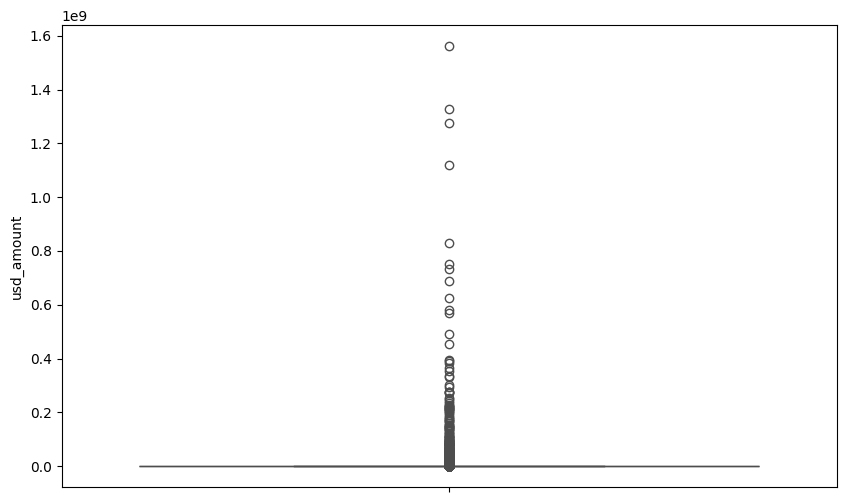

In [117]:
#check outlier of the text length
f, axes = plt.subplots(ncols=1, figsize=(10, 6))
sns.boxplot(y=df['usd_amount'] ,color='grey')
plt.show()

In [118]:
outliers = detect_outliers(
    df,
    ['usd_amount'],
)
print(format_title_output("OUTLIERS DETECTION - AMOUNT RECEIVED & PAID"))
print(json.dumps(outliers, indent=4))

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
OUTLIERS DETECTION - AMOUNT RECEIVED & PAID
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

{
    "usd_amount": {
        "max_outlier_value": 1561370086.0,
        "number_of_outliers": 8810,
        "lower_bound": -39238.7825,
        "upper_bound": 65452.497500000005
    }
}


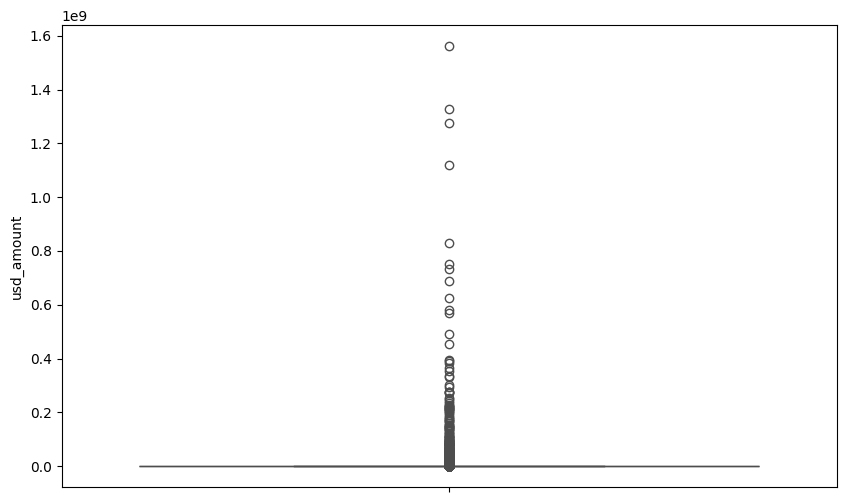

In [119]:
#Remove outlierts 
df_no_outliers = df[df['usd_amount'] <= outliers['usd_amount']['upper_bound']]

#check outlier of the text length
f, axes = plt.subplots(ncols=1, figsize=(10, 6))
sns.boxplot(y=df['usd_amount'] ,color='grey')
plt.show()

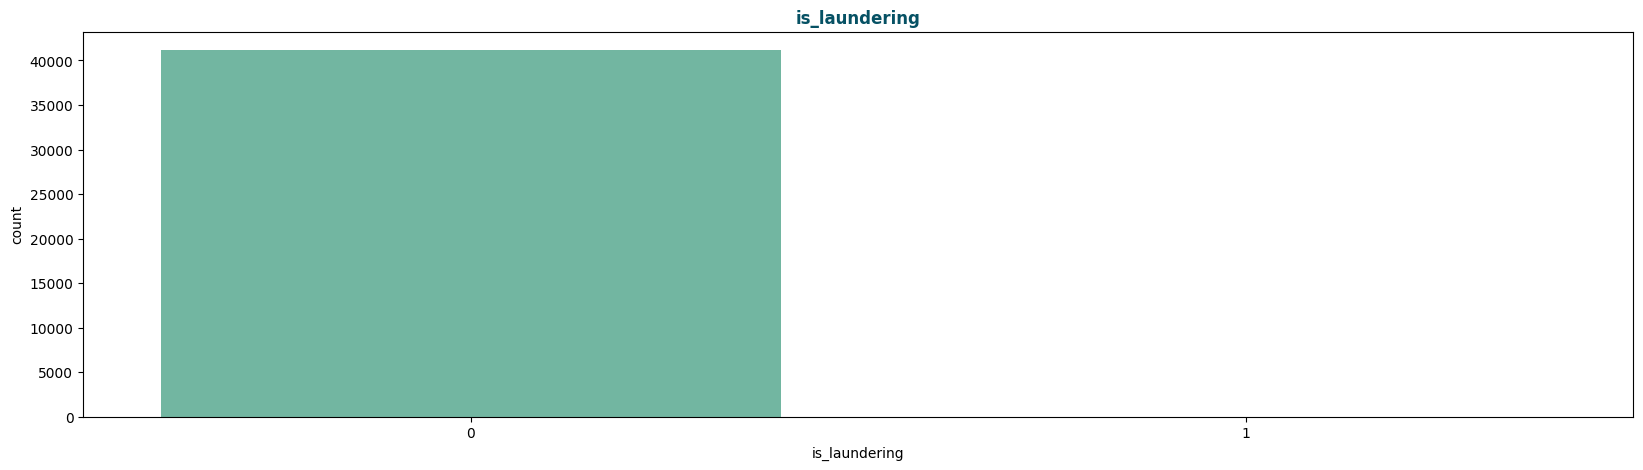

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
IS_LAUNDERING VALUE COUNTS
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

is_laundering
0    41189
1        1
Name: count, dtype: int64


In [120]:
create_bar_plot(
    df=df_no_outliers,
    column_name='is_laundering',
    title='is_laundering'
)

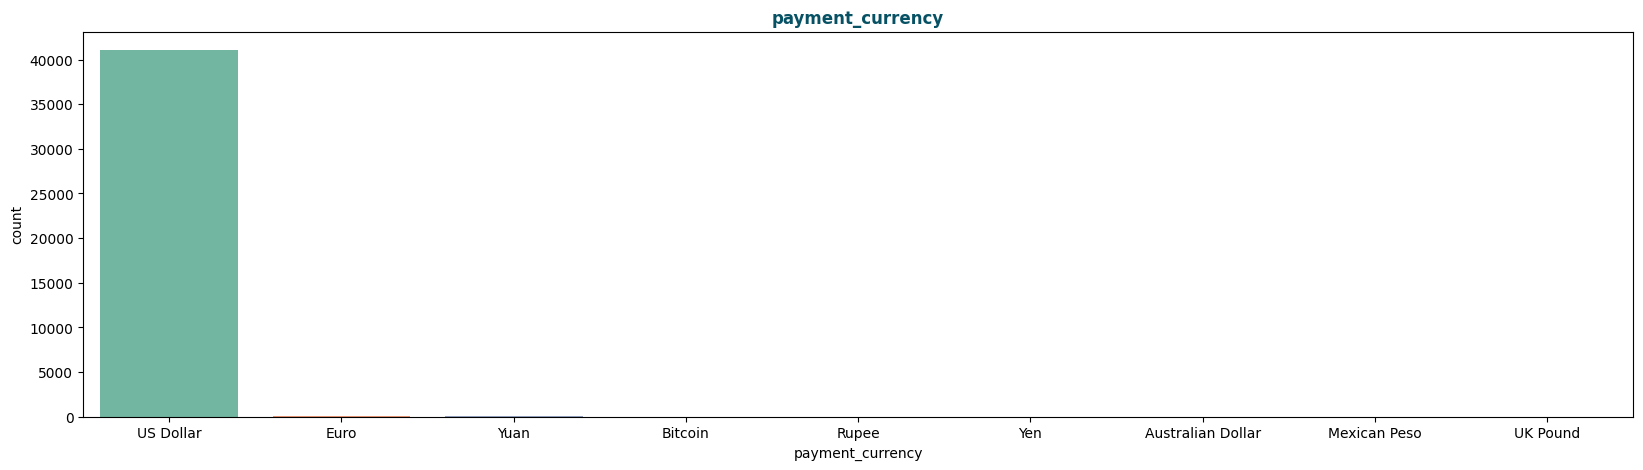

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
PAYMENT_CURRENCY VALUE COUNTS
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

payment_currency
US Dollar            41059
Euro                    57
Yuan                    36
Bitcoin                 17
Rupee                   12
Yen                      6
Australian Dollar        1
Mexican Peso             1
UK Pound                 1
Name: count, dtype: int64


In [121]:
create_bar_plot(
    df=df_no_outliers,
    column_name='payment_currency',
    title='payment_currency'
)

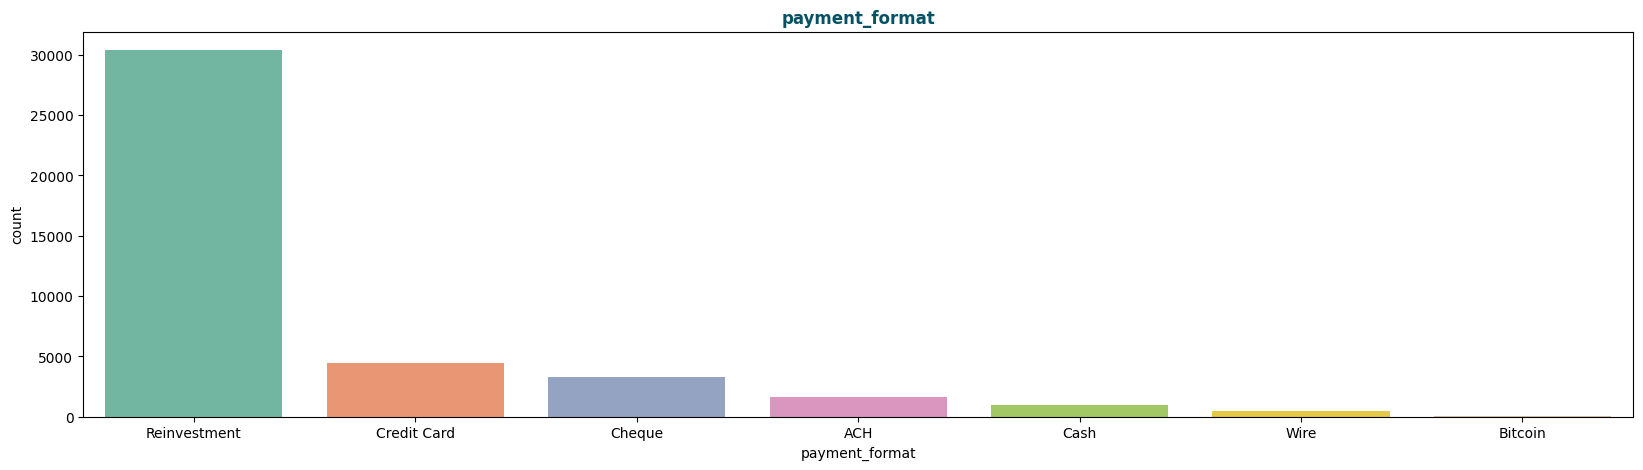

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
PAYMENT_FORMAT VALUE COUNTS
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

payment_format
Reinvestment    30392
Credit Card      4448
Cheque           3294
ACH              1616
Cash              956
Wire              466
Bitcoin            18
Name: count, dtype: int64


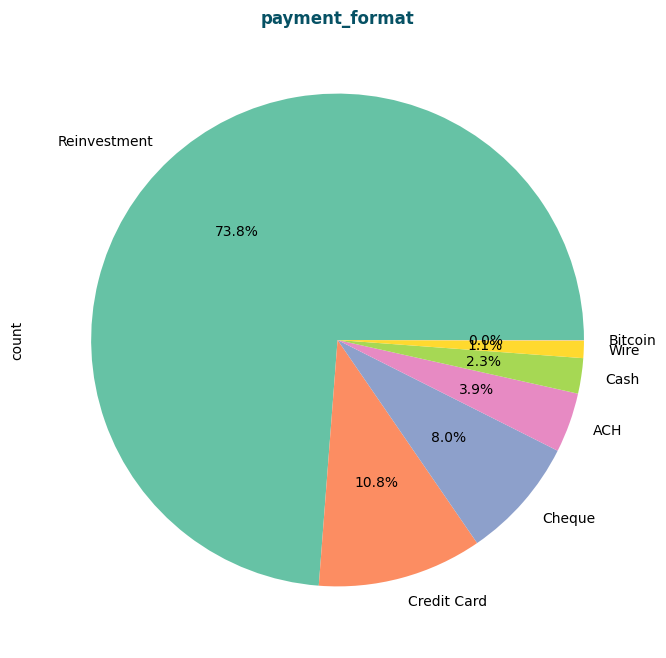

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
PAYMENT_FORMAT VALUE COUNTS
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

payment_format
Reinvestment    30392
Credit Card      4448
Cheque           3294
ACH              1616
Cash              956
Wire              466
Bitcoin            18
Name: count, dtype: int64


In [122]:
create_bar_plot(
    df=df_no_outliers,
    column_name='payment_format',
    title='payment_format'
)

create_pie_plot(
    df=df_no_outliers,
    column_name='payment_format',
    title='payment_format'
)

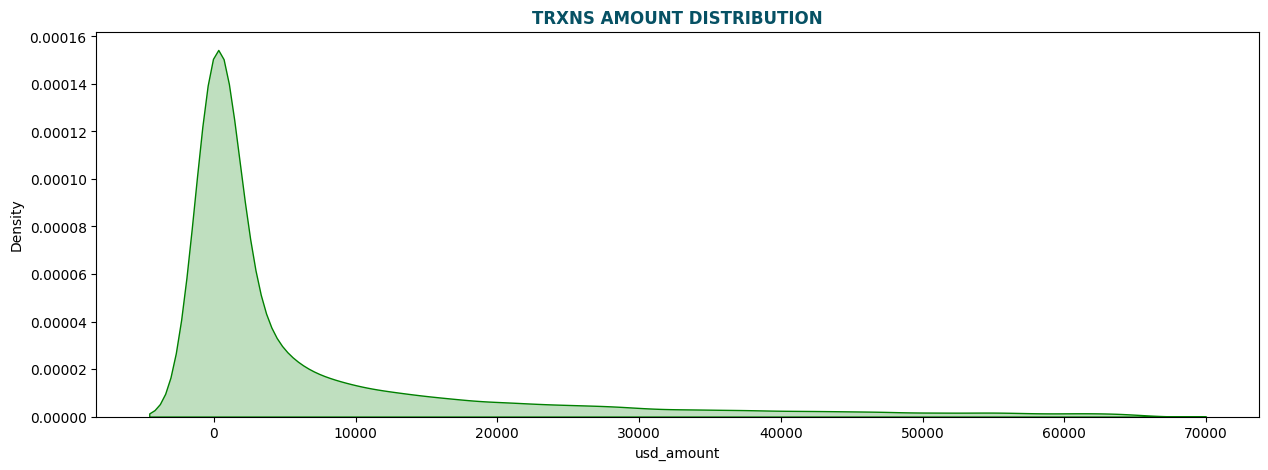

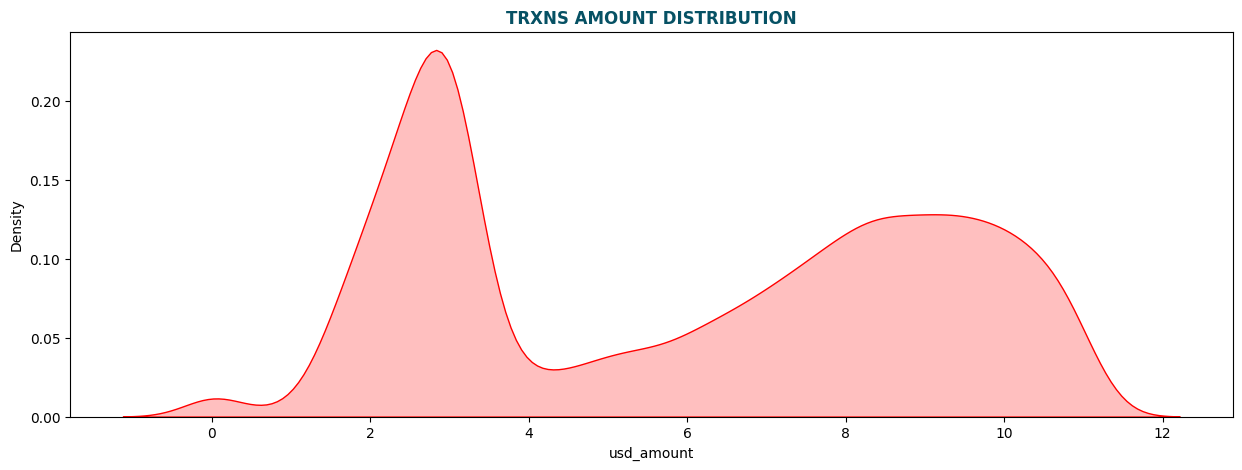

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
TRXNS AMOUNT DISTRIBUTION
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

count    41190.000000
mean         6.013214
std          3.142310
min          0.003923
25%          2.893146
50%          6.479554
75%          8.909046
max         11.088812
Name: usd_amount, dtype: float64


In [123]:
create_kde_plot(df_no_outliers, 'usd_amount', 'TRXNS AMOUNT DISTRIBUTION')
create_kde_plot_with_log(df_no_outliers, 'usd_amount', 'TRXNS AMOUNT DISTRIBUTION')

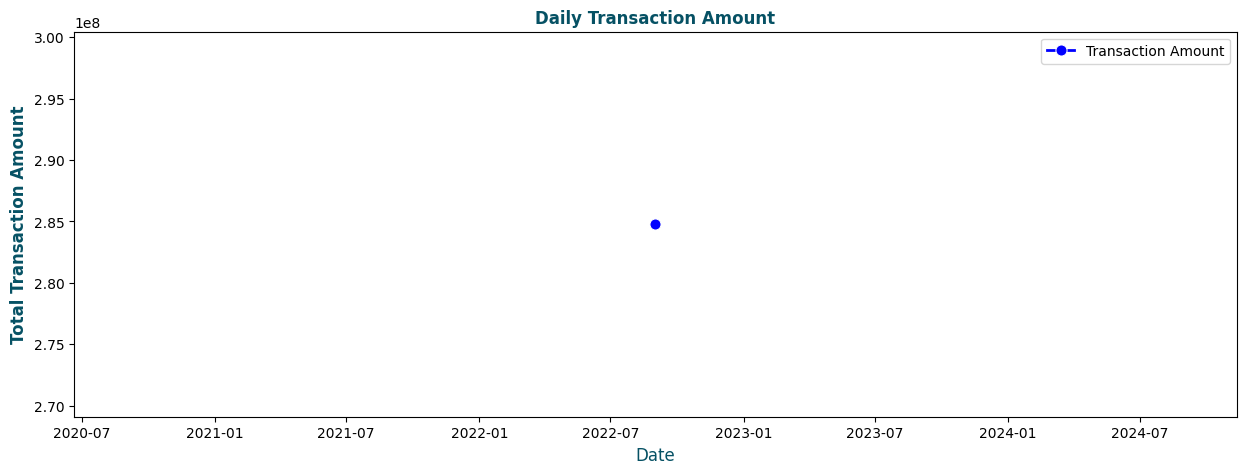

In [124]:
create_transaction_line_plot(df_no_outliers, 'timestamp', 'usd_amount', 'Daily Transaction Amount')

### Data Preprocessing

In [125]:
# start preprocessing on none outliers dataframe first 
new_df = df_no_outliers.copy()

In [126]:
print(format_title_output("RECHECK THE DATA INFO"))
print(new_df.info())

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
RECHECK THE DATA INFO
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

<class 'pandas.core.frame.DataFrame'>
Index: 41190 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   timestamp           41190 non-null  datetime64[ns]
 1   from_bank           41190 non-null  int64         
 2   account             41190 non-null  object        
 3   to_bank             41190 non-null  int64         
 4   account.1           41190 non-null  object        
 5   amount_received     41190 non-null  float64       
 6   receiving_currency  41190 non-null  object        
 7   amount_paid         41190 non-null  float64       
 8   payment_currency    41190 non-null  object        
 9   payment_format      41190 non-null  object        

In [127]:
print(format_title_output("DROP THE UNNESESSAR COLUMNS"))
columns_to_drop = ['timestamp', 'amount_paid', 'payment_currency']
new_df.drop(columns_to_drop, axis=1, inplace=True)
new_df.head()

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
DROP THE UNNESESSAR COLUMNS
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++



,from_bank,account,to_bank,account.1,amount_received,receiving_currency,payment_format,is_laundering,usd_amount
0,10,8000EBD30,10,8000EBD30,3697.34,US Dollar,Reinvestment,0,3697.34
1,3208,8000F4580,1,8000F5340,0.01,US Dollar,Cheque,0,0.01
2,3209,8000F4670,3209,8000F4670,14675.57,US Dollar,Reinvestment,0,14675.57
3,12,8000F5030,12,8000F5030,2806.97,US Dollar,Reinvestment,0,2806.97
4,10,8000F5200,10,8000F5200,36682.97,US Dollar,Reinvestment,0,36682.97


In [129]:
numeric_columns = new_df.select_dtypes(exclude="object").columns
classification_columns = new_df.select_dtypes(include = "object").columns
print(format_title_output("NUMERICAL COLUMNS"))
for i,j in enumerate(numeric_columns):
    print(i, ":" , j)
print(format_title_output("CLASSIFICATIONS COLUMNS"))
for i,j in enumerate(classification_columns):
    print(i, ":" , j)

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
NUMERICAL COLUMNS
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

0 : from_bank
1 : to_bank
2 : amount_received
3 : is_laundering
4 : usd_amount
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
CLASSIFICATIONS COLUMNS
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

0 : account
1 : account.1
2 : receiving_currency
3 : payment_format
